In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', 5000)


In [45]:
r1 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.ip.three_upstream.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
r2 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.ip.five_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
r3 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.ip.three_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
r4 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.ip.five_downstream.se.raw_density_matrix.csv',
                    sep=',',index_col=0)

ir1 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.input.three_upstream.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
ir2 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.input.five_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
ir3 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.input.three_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
ir4 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.input.five_downstream.se.raw_density_matrix.csv',
                    sep=',',index_col=0)

In [50]:
def entropy_of_reads(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    plot mean
    """
    ipdf = density[density.sum(axis=1) > min_density_threshold]
    indf = input_density[input_density.sum(axis=1) > min_density_threshold]
    
    min_ip_read_number = min([item for item in ipdf.unstack().values if item > 0])
    min_in_read_number = min([item for item in indf.unstack().values if item > 0])
    min_read_number = min(min_ip_read_number,min_in_read_number)
    
    ipdf = ipdf + min_read_number
    indf = indf + min_read_number
    
    ipdfdiv = ipdf.div(1000000)
    indfdiv = indf.div(1000000)
    
    dft = pd.merge(ipdfdiv,indfdiv,how='left',left_index=True,right_index=True).fillna(min_read_number)
    
    ipdfdiv = dft.filter(regex='\d+_x')
    indfdiv = dft.filter(regex='\d+_y')
    
    ipdfdiv = ipdfdiv.rename(columns=lambda x: x.replace('_x', ''))
    indfdiv = indfdiv.rename(columns=lambda x: x.replace('_y', ''))
    
    en = ipdfdiv.multiply(np.log2(ipdfdiv.div(indfdiv)))
    
    return en

In [59]:
import seaborn as sns
from gscripts.general import dataviz
def four_frame(region1, region2, region3, region4, 
               title, output_file, color='red'):
    num_rows = 1
    num_cols = 4
    
        
    with dataviz.Figure(output_file, figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
            
        min_height = min(min(region1),min(region2),min(region3),min(region4))
        max_height = max(max(region1),max(region2),max(region3),max(region4))
            
        linewidth = 2.5
        ax = fig.add_subplot(1,4,1)
        ax.plot(region1, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(three_upstream_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
        sns.despine(ax=ax)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-exon_offset, intron_offset+1, 50))
        ax.set_ylabel("Mean Read Density")
            
        ax = fig.add_subplot(1,4,2)
        ax.plot(region2, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(five_skipped_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-intron_offset, exon_offset+1, 50))
        ax.set_yticklabels([])
            
        ax = fig.add_subplot(1,4,3)
        ax.plot(region3, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(three_skipped_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-exon_offset, intron_offset+1, 50))
        ax.set_yticklabels([])
            
        ax = fig.add_subplot(1,4,4)
        ax.plot(region4, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(five_downstream_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-intron_offset, exon_offset+1, 50))
        ax.set_yticklabels([])
        plt.suptitle(title,y=1.03)
    # ax.clear()

In [53]:
def calculate_pdf(density, min_density_threshold = 0):
    densities = density.replace(-1, np.nan)   
    df = densities[densities.sum(axis=1) > min_density_threshold]
    min_normalized_read_number = min([item for item in df.unstack().values if item > 0])
    df = df + min_normalized_read_number
    pdf = df.div(df.sum(axis=1), axis=0)
  
    return pdf # , mean, sem

def normalize_and_subtract(density, input_density, min_density_threshold = 0):
        
    pdf = calculate_pdf(density,min_density_threshold)
    input_pdf = calculate_pdf(input_density,min_density_threshold)
        
    subtracted = pd.DataFrame(pdf.mean() - input_pdf.mean()).T
      
    return subtracted

In [56]:
e1 = entropy_of_reads(r1, ir1, 0).mean()
e2 = entropy_of_reads(r2, ir2, 0).mean()
e3 = entropy_of_reads(r3, ir3, 0).mean()
e4 = entropy_of_reads(r4, ir4, 0).mean()

In [57]:
n1 = normalize_and_subtract(r1, ir1, 0).mean()
n2 = normalize_and_subtract(r2, ir2, 0).mean()
n3 = normalize_and_subtract(r3, ir3, 0).mean()
n4 = normalize_and_subtract(r4, ir4, 0).mean()

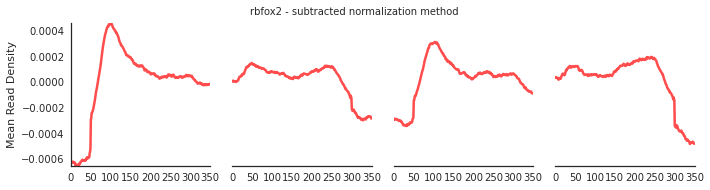

In [61]:
output_file = '/home/bay001/projects/maps_20160420/permanent_data/test.svg'
four_frame(n1,n2,n3,n4,'rbfox2 - subtracted normalization method',output_file)

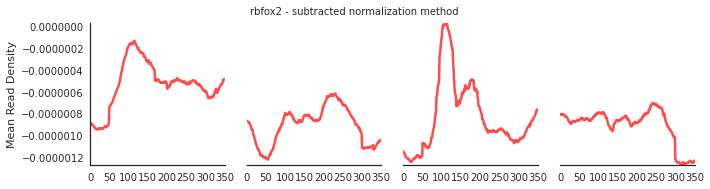

In [62]:
output_file = '/home/bay001/projects/maps_20160420/permanent_data/test.svg'
four_frame(e1, e2, e3, e4,'rbfox2 - subtracted normalization method',output_file)

### Strange that we see that 'hump.' Let's explicitly print everything in the function...

In [63]:
r3 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.ip.three_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)
ir3 = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-10-2016/204_01_RBFOX2.input.three_skipped.se.raw_density_matrix.csv',
                    sep=',',index_col=0)


In [85]:
r3 = r3.ix[:1]
r3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.0,0.0,0.0,0.0,0.0,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
def entropy_of_reads(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    plot mean
    """
    ipdf = density[density.sum(axis=1) > min_density_threshold]
    indf = input_density[input_density.sum(axis=1) > min_density_threshold]
    ipdfp = ipdf
    indfp = indf
    min_ip_read_number = min([item for item in ipdf.unstack().values if item > 0])
    min_in_read_number = min([item for item in indf.unstack().values if item > 0])
    min_read_number = min(min_ip_read_number,min_in_read_number)
    
    ipdf = ipdf + min_read_number
    indf = indf + min_read_number
    
    ipdfdivp = ipdf.div(1000000)
    indfdivp = indf.div(1000000)
    
    dft = pd.merge(ipdfdivp,indfdivp,how='left',left_index=True,right_index=True).fillna(min_read_number)
    
    ipdfdiv = dft.filter(regex='\d+_x')
    indfdiv = dft.filter(regex='\d+_y')
    
    ipdfdiv = ipdfdiv.rename(columns=lambda x: x.replace('_x', ''))
    indfdiv = indfdiv.rename(columns=lambda x: x.replace('_y', ''))
    
    en = ipdfdiv.multiply(np.log2(ipdfdiv.div(indfdiv)))
    
    return ipdfp, indfp, ipdf, indf, min_read_number, ipdfdivp, indfdivp, dft, ipdfdiv, indfdiv, en

In [76]:
ipdfp, indfp, ipdf, indf, min_read_number, ipdfdivp, indfdivp, dft, ipdfdiv, indfdiv, en = entropy_of_reads(r3, ir3, 0)

In [95]:
# original dataframe
pd.concat([r3,ir3[:1]],axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.00000,0.00000,0.00000,0.00000,0.00000,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.26555,0.26555,0.26555,0.26555,0.26555,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.265550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [88]:
# dataframe after adding the 'minimum read number'
print(min_read_number)
pd.concat([r3,ipdf],axis=0)

0.233893454075


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.000000,0.000000,0.000000,0.000000,0.000000,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.233893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [89]:
# after dividing by 1000000:
pd.concat([r3,ipdf,ipdfdivp],axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,2.338935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00

In [92]:
# merge the two ip and input dataframes together and fill empty (regions in ip where input signal doesn't exist) with min_read_number:
dft

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,40_x,41_x,42_x,43_x,44_x,45_x,46_x,47_x,48_x,49_x,50_x,51_x,52_x,53_x,54_x,55_x,56_x,57_x,58_x,59_x,60_x,61_x,62_x,63_x,64_x,65_x,66_x,67_x,68_x,69_x,70_x,71_x,72_x,73_x,74_x,75_x,76_x,77_x,78_x,79_x,80_x,81_x,82_x,83_x,84_x,85_x,86_x,87_x,88_x,89_x,90_x,91_x,92_x,93_x,94_x,95_x,96_x,97_x,98_x,99_x,100_x,101_x,102_x,103_x,104_x,105_x,106_x,107_x,108_x,109_x,110_x,111_x,112_x,113_x,114_x,115_x,116_x,117_x,118_x,119_x,120_x,121_x,122_x,123_x,124_x,125_x,126_x,127_x,128_x,129_x,130_x,131_x,132_x,133_x,134_x,135_x,136_x,137_x,138_x,139_x,140_x,141_x,142_x,143_x,144_x,145_x,146_x,147_x,148_x,149_x,150_x,151_x,152_x,153_x,154_x,155_x,156_x,157_x,158_x,159_x,160_x,161_x,162_x,163_x,164_x,165_x,166_x,167_x,168_x,169_x,170_x,171_x,172_x,173_x,174_x,175_x,176_x,177_x,178_x,179_x,180_x,181_x,182_x,183_x,184_x,185_x,186_x,187_x,188_x,189_x,190_x,191_x,192_x,193_x,194_x,195_x,196_x,197_x,198_x,199_x,200_x,201_x,202_x,203_x,204_x,205_x,206_x,207_x,208_x,209_x,210_x,211_x,212_x,213_x,214_x,215_x,216_x,217_x,218_x,219_x,220_x,221_x,222_x,223_x,224_x,225_x,226_x,227_x,228_x,229_x,230_x,231_x,232_x,233_x,234_x,235_x,236_x,237_x,238_x,239_x,240_x,241_x,242_x,243_x,244_x,245_x,246_x,247_x,248_x,249_x,250_x,251_x,252_x,253_x,254_x,255_x,256_x,257_x,258_x,259_x,260_x,261_x,262_x,263_x,264_x,265_x,266_x,267_x,268_x,269_x,270_x,271_x,272_x,273_x,274_x,275_x,276_x,277_x,278_x,279_x,280_x,281_x,282_x,283_x,284_x,285_x,286_x,287_x,288_x,289_x,290_x,291_x,292_x,293_x,294_x,295_x,296_x,297_x,298_x,299_x,300_x,301_x,302_x,303_x,304_x,305_x,306_x,307_x,308_x,309_x,310_x,311_x,312_x,313_x,314_x,315_x,316_x,317_x,318_x,319_x,320_x,321_x,322_x,323_x,324_x,325_x,326_x,327_x,328_x,329_x,330_x,331_x,332_x,333_x,334_x,335_x,336_x,337_x,338_x,339_x,340_x,341_x,342_x,343_x,344_x,345_x,346_x,347_x,348_x,349_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y,32_y,33_y,34_y,35_y,36_y,37_y,38_y,39_y,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y,50_y,51_y,52_y,53_y,54_y,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101_y,102_y,103_y,104_y,105_y,106_y,107_y,108_y,109_y,110_y,111_y,112_y,113_y,114_y,115_y,116_y,117_y,118_y,119_y,120_y,121_y,122_y,123_y,124_y,125_y,126_y,127_y,128_y,129_y,130_y,131_y,132_y,133_y,134_y,135_y,136_y,137_y,138_y,139_y,140_y,141_y,142_y,143_y,144_y,145_y,146_y,147_y,148_y,149_y,150_y,151_y,152_y,153_y,154_y,155_y,156_y,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y,167_y,168_y,169_y,170_y,171_y,172_y,173_y,174_y,175_y,176_y,177_y,178_y,179_y,180_y,181_y,182_y,183_y,184_y,185_y,186_y,187_y,188_y,189_y,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y,200_y,201_y,202_y,203_y,204_y,205_y,206_y,207_y,208_y,209_y,210_y,211_y,212_y,213_y,214_y,215_y,216_y,217_y,218_y,219_y,220_y,221_y,222_y,223_y,224_y,225_y,226_y,227_y,228_y,229_y,230_y,231_y,232_y,233_y,234_y,235_y,236_y,237_y,238_y,239_y,240_y,241_y,242_y,243_y,244_y,245_y,246_y,247_y,248_y,249_y,250_y,251_y,252_y,253_y,254_y,255_y,256_y,257_y,258_y,259_y,260_y,261_y,262_y,263_y,264_y,265_y,266_y,267_y,268_y,269_y,270_y,271_y,272_y,273_y,274_y,275_y,276_y,277_y,278_y,279_y,280_y,281_y,282_y,283_y,284_y,285_y,286_y,287_y,288_y,289_y,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y,300_y,301_y,302_y,303_y,304_y,305_y,306_y,307_y,308_y,309_y,310_y,311_y,312_y,313_y,314_y,315_y,316_y,317_y,318_y,319_y,320_y,321_y,322_y,323_y,324_y,325_y,326_y,327_y,328_y,329_y,330_y,331_y,332_y,333_y,334_y,335_y,336_y,337_y,338_y,339_y,340_y,341_y,342_y,343_y,344_y,345_y,346_y,347_y,348_y,349_y
chr10:100150355:100

In [93]:
# separate the two dataframes again:
pd.concat([ipdfdiv,indfdiv],axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,4.677869e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07,2.338935e-07